## CIFAR10 Image Classification

In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645_assignment02_team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team_(team number)_FCN.h5 (fully connected model) and team_(team number)_FCN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [47]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

## 1. Load your data

In [48]:
# Loading the dataset using the keras function
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(X_dev.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## 2. Explore your data 

In [49]:
# Use this space to explore you datasets
# Create additional cells as you see fit

print("\nNumber of classes:",np.unique(Y_dev).size)
print("\nClasses:",np.unique(Y_dev))
print("\nDevelopment set")
print("Images: ",X_dev.shape)
print("Labels shape:",Y_dev.shape)
print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)


Number of classes: 10

Classes: [0 1 2 3 4 5 6 7 8 9]

Development set
Images:  (50000, 32, 32, 3)
Labels shape: (50000, 1)

Test set
Images:  (10000, 32, 32, 3)
Labels shape:  (10000, 1)


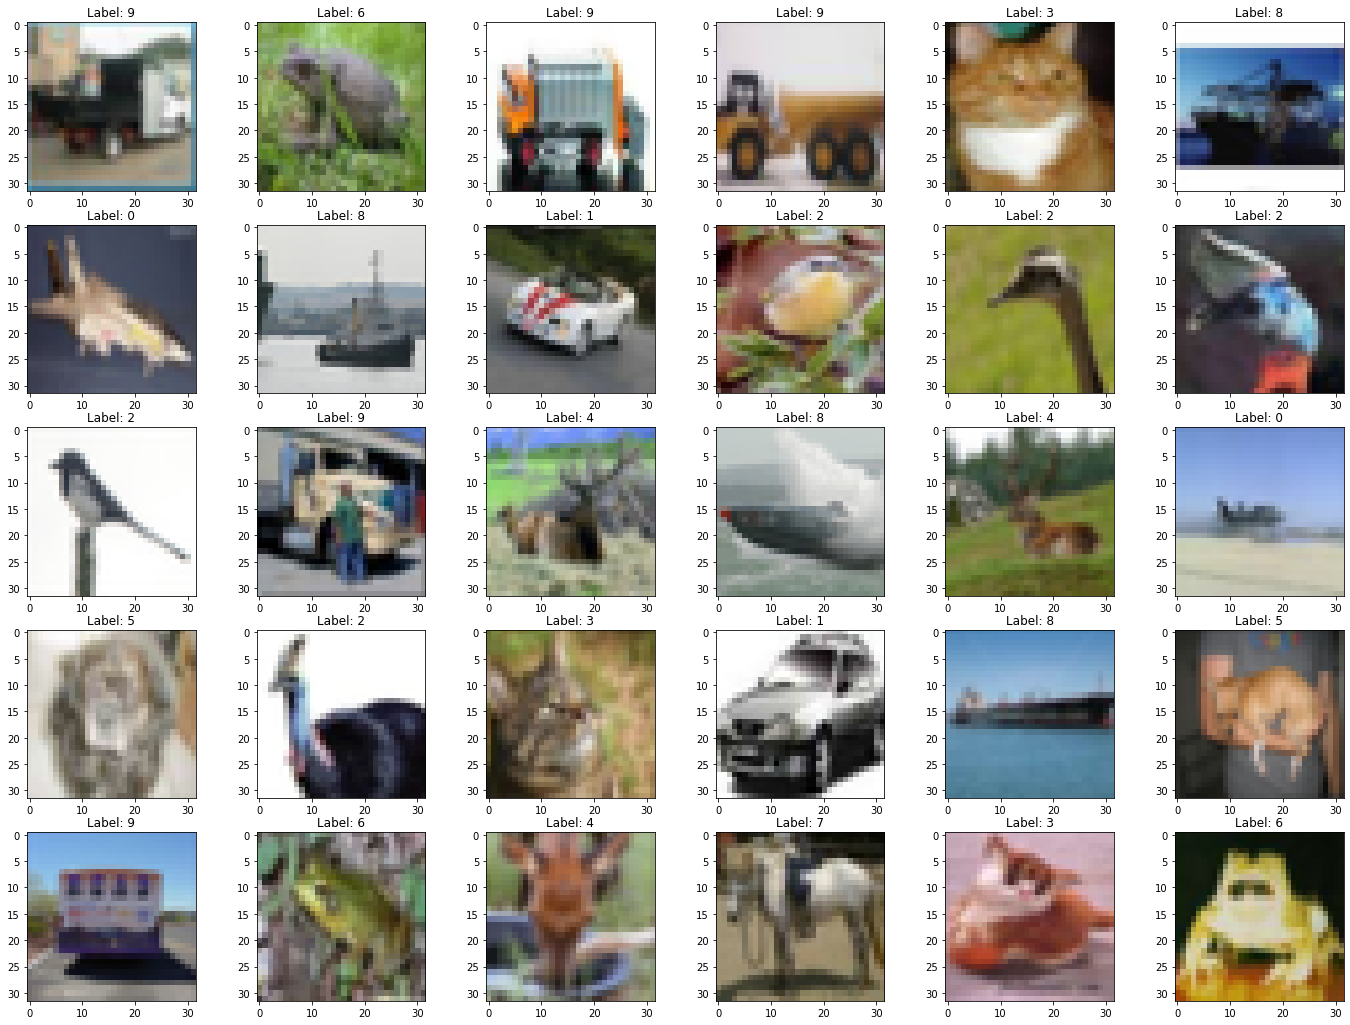

In [50]:
# Displaying some samples from the development set
# label 0=airplane, label 1=automobile, label 2=bird, label 3 =cat, label 4=deer, 
# label 5=dog, label 6= frog, label 7=horse, label 8=ship , label 9 =truck
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [51]:
# shuffling the sample and splitting them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.95*X_dev.shape[0]) # Splitting the development set into train and validation set

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (47500, 32, 32, 3)
Labels shape:  (47500, 1)

Validation set
Images:  (2500, 32, 32, 3)
Labels shape:  (2500, 1)


## 3. Represent your labels using one hot encoding

In [52]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
[[0]
 [7]
 [7]
 [4]
 [4]]

One hot encoded labels:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [53]:
# Displaying the min, max, mean and std values of train and validation set
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0 255 120.71357411595395 64.14981778730267
0 255 120.59339427083333 64.15487272965392


## 4. Data scaling and Data augmentation

In [54]:
# Experiment with different data scaling methods
# Create your data augmentation object to improve training
# set your batch size
# Data Scaling using Sample wise Normalization (using the statistics of the training set)
norm_type = 0 # norm_type=0-> min-max; norm_type=1-> standardization

if norm_type == 0: # min-max Normalization
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1: # standardization
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

In [64]:
# Data Augmentation
batch_size = 128
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size)

0.39780223 0.2808385
0.0 1.0


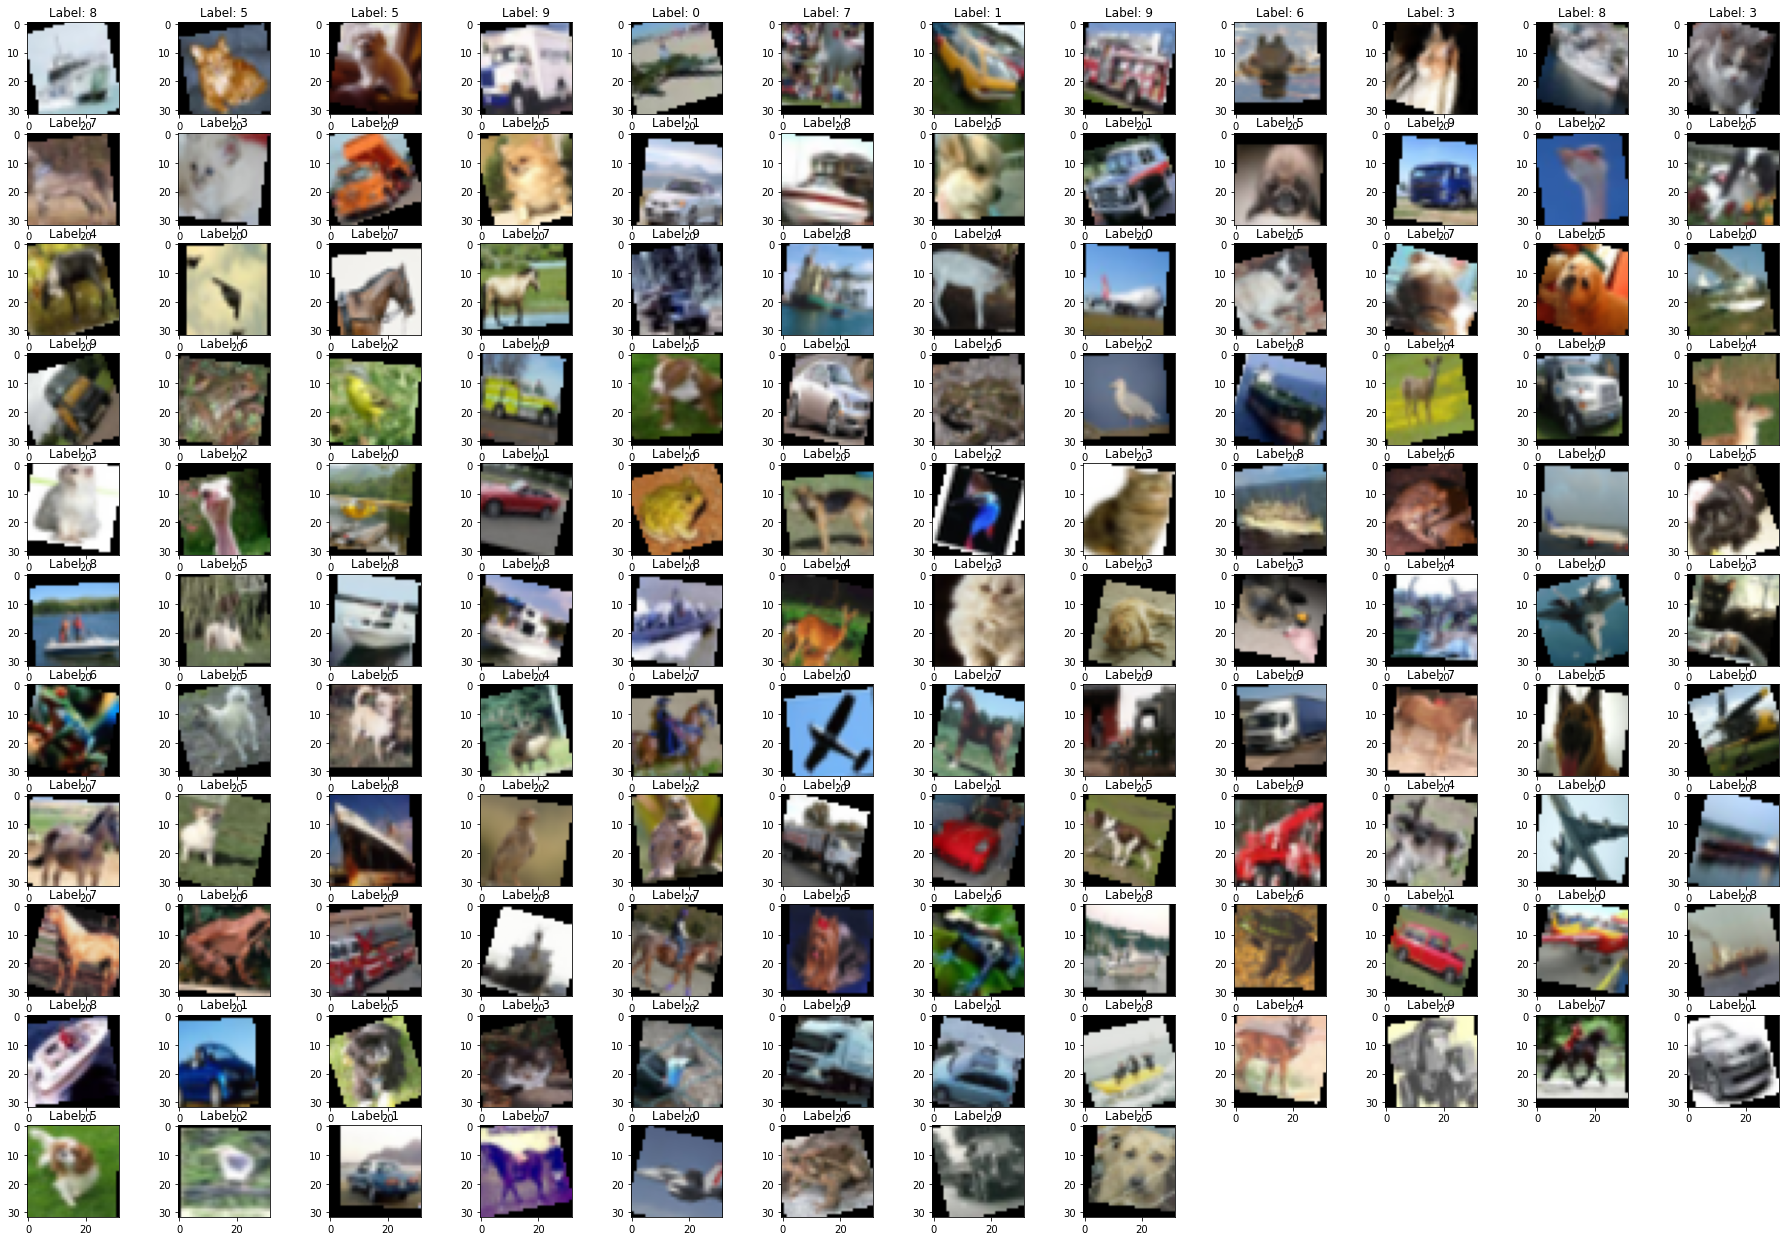

In [65]:
# Disaplying some samples from the development set
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(12,12,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title("Label: %s" %Ybatch[ii].argmax())
plt.show()

## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [66]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_fully_connected(ishape = (32,32,3),k = 10, lr=1e-3): #ishape=shape of model k=number of classes lr=learning rate
    model_input = tf.keras.layers.Input(shape = ishape)
    model_input_flatten = tf.keras.layers.Flatten()(model_input)
    l1 = tf.keras.layers.Dense(512, activation = 'relu')(model_input_flatten)
    l2 = tf.keras.layers.Dense(512, activation = 'relu')(l1)
    l3 = tf.keras.layers.Dense(512, activation = 'relu')(l2)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(l3)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [67]:
model = my_model_fully_connected()
print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
Total params: 2,103,818
Trainable params: 2,103,818
Non-trainable params: 0
_________________________________________________

## 6. Define your callbacks (save your model, patience, etc.)

In [68]:
model_name_fcn = "team_16_FCN.h5"
# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_fcn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [69]:
history = model.fit(train_flow,batch_size = batch_size, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/1000
372/372 [==============================] - 19s 50ms/step - loss: 2.0574 - accuracy: 0.2379 - val_loss: 1.8472 - val_accuracy: 0.3336
Epoch 2/1000
372/372 [==============================] - 19s 50ms/step - loss: 1.8187 - accuracy: 0.3394 - val_loss: 1.7533 - val_accuracy: 0.3648
Epoch 3/1000
372/372 [==============================] - 19s 50ms/step - loss: 1.7335 - accuracy: 0.3747 - val_loss: 1.6928 - val_accuracy: 0.3812
Epoch 4/1000
372/372 [==============================] - 19s 50ms/step - loss: 1.6793 - accuracy: 0.3917 - val_loss: 1.6808 - val_accuracy: 0.3840
Epoch 5/1000
372/372 [==============================] - 18s 49ms/step - loss: 1.6617 - accuracy: 0.3991 - val_loss: 1.6789 - val_accuracy: 0.3908
Epoch 6/1000
372/372 [==============================] - 19s 52ms/step - loss: 1.6167 - accuracy: 0.4150 - val_loss: 1.6048 - val_accuracy: 0.4124
Epoch 7/1000
372/372 [==============================] - 20s 53ms/step - loss: 1.6165 - accuracy: 0.4161 - val_loss: 1.6173 -

## 8. Test your model

313/313 [==============================] - 1s 2ms/step - loss: 1.2766 - accuracy: 0.5483
4517


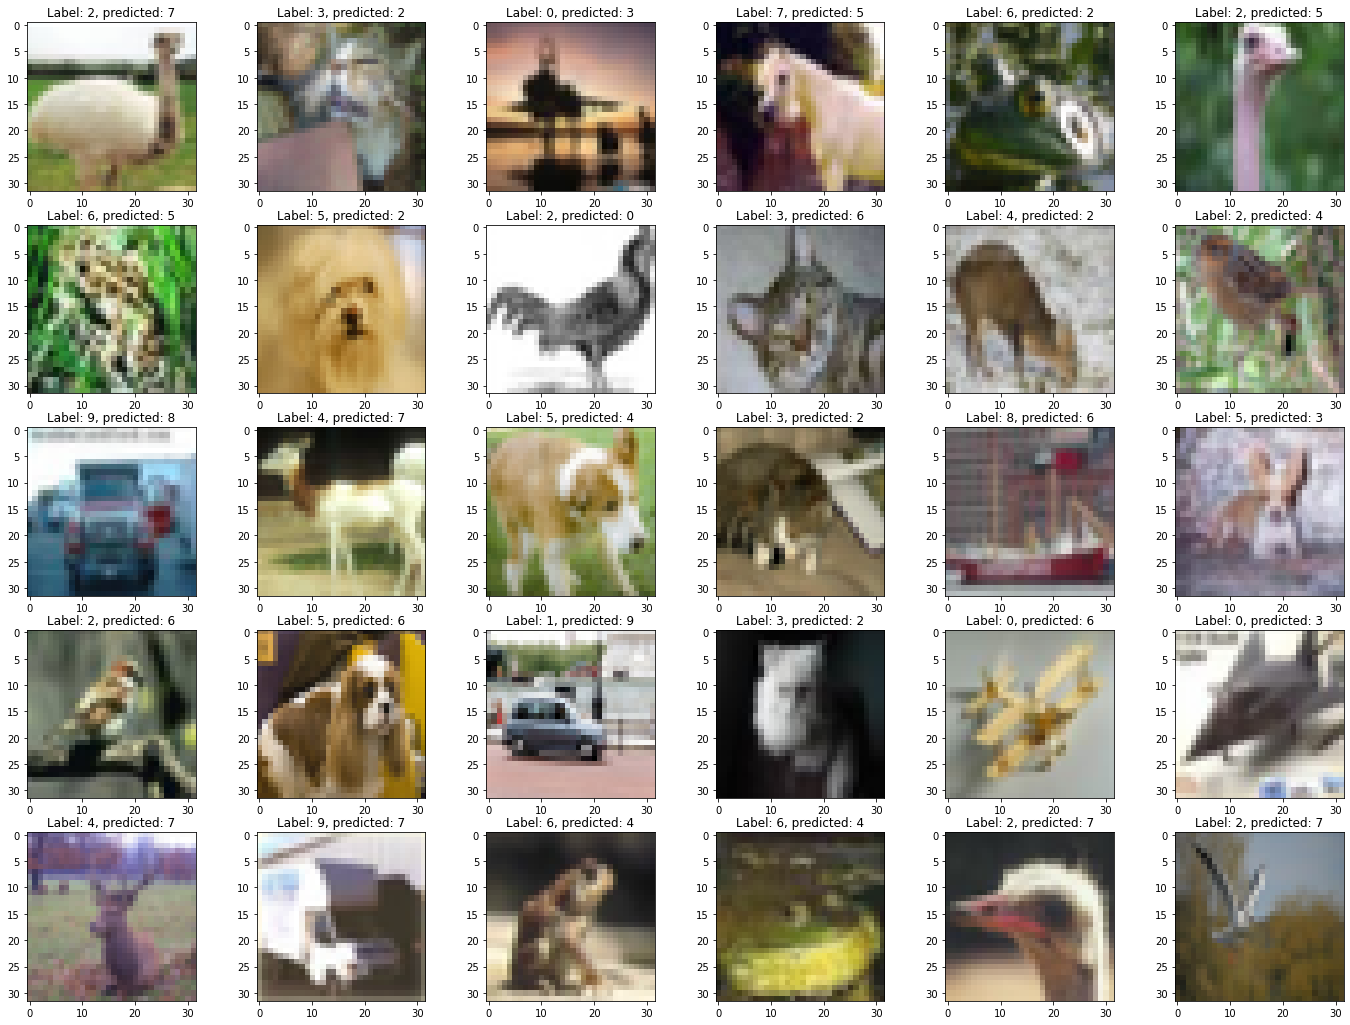

In [70]:
model.load_weights(model_name_fcn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set that were wrongly predicted
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [71]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
# k=Number of classes, ishape=input image shape, lr=learning rate
def my_model_cnn(ishape = (32,32,3),k = 10, lr=1e-3):
    model_input = tf.keras.layers.Input(shape = ishape) 
    l1 = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(model_input)
    l2 = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(l1)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2) #Dropout to prevent overfitting
    l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)# a (2x2) maxpooling layer
    l4 = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(l3)
    l5 = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(l4)
    l5_drop = tf.keras.layers.Dropout(0.25)(l5) #Droupout to prevent overfitting
    l6 = tf.keras.layers.MaxPool2D((2,2))(l5_drop)# a (2x2) maxpooling layer
    l7 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(l6)
    l8 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(l7)
    l8_drop = tf.keras.layers.Dropout(0.25)(l8)#Dropout to prevent overfitting
    flat = tf.keras.layers.Flatten()(l8_drop) 
    out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [72]:
model = my_model_cnn()
print(model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3692

## 6. Define your callbacks (save your model, patience, etc.)

In [73]:
model_name_cnn = "team_16_CNN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_cnn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [74]:
# train your model - decide for how many epochs
history = model.fit(train_flow,batch_size = batch_size, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/1000
372/372 [==============================] - 91s 242ms/step - loss: 1.9410 - accuracy: 0.2809 - val_loss: 1.5901 - val_accuracy: 0.4484
Epoch 2/1000
372/372 [==============================] - 88s 236ms/step - loss: 1.4924 - accuracy: 0.4578 - val_loss: 1.4378 - val_accuracy: 0.4924
Epoch 3/1000
372/372 [==============================] - 91s 245ms/step - loss: 1.3184 - accuracy: 0.5259 - val_loss: 1.3017 - val_accuracy: 0.5552
Epoch 4/1000
372/372 [==============================] - 83s 223ms/step - loss: 1.2107 - accuracy: 0.5706 - val_loss: 1.1865 - val_accuracy: 0.5964
Epoch 5/1000
372/372 [==============================] - 90s 241ms/step - loss: 1.1066 - accuracy: 0.6040 - val_loss: 1.1067 - val_accuracy: 0.6228
Epoch 6/1000
372/372 [==============================] - 91s 243ms/step - loss: 1.0409 - accuracy: 0.6341 - val_loss: 1.0182 - val_accuracy: 0.6556
Epoch 7/1000
372/372 [==============================] - 84s 226ms/step - loss: 0.9751 - accuracy: 0.6565 - val_loss: 0

## 8. Test your model

313/313 [==============================] - 5s 15ms/step - loss: 0.6154 - accuracy: 0.7939
2061


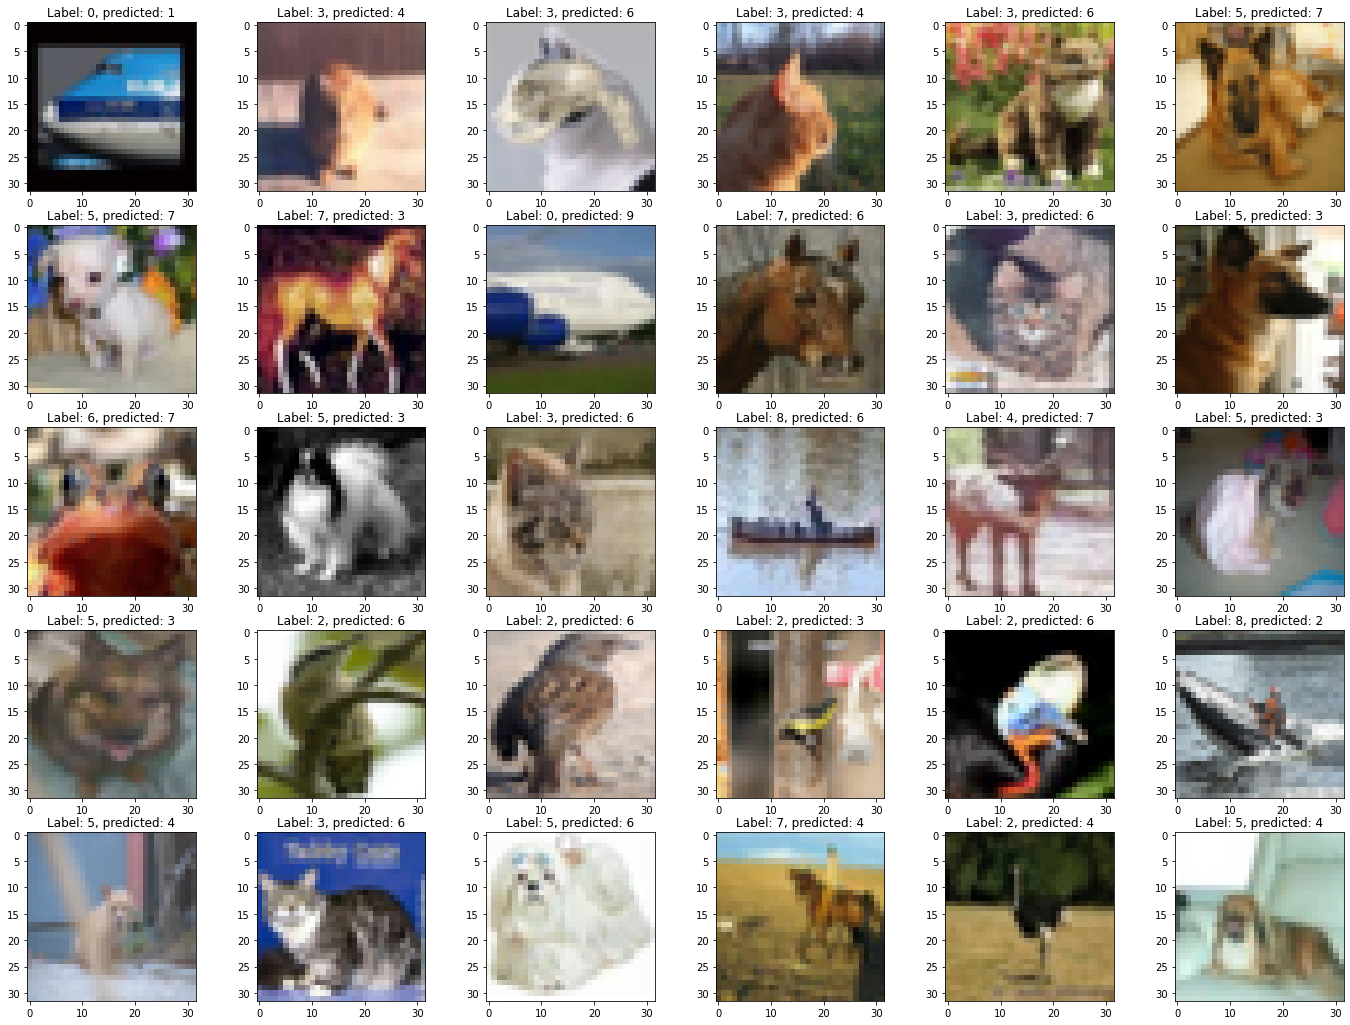

In [76]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set that were wrongly predicted
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()